# Laboratorium 4 - Algorytmy grupowania danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, make_scorer
from sklearn.cluster import KMeans, DBSCAN


## 1. Wczytanie zbioru Abalone, AutoEDA

In [2]:
abalone = fetch_ucirepo(id=1) 
df = abalone.data.original
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
abalone.metadata['additional_info']['summary']

'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.\r\n\r\nFrom the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).'

In [4]:
abalone.variables

,name,role,type,demographic,description,units,missing_values
0,Sex,Feature,Categorical,None,"M, F, and I (infant)",None,no
1,Length,Feature,Continuous,None,Longest shell measurement,mm,no
2,Diameter,Feature,Continuous,None,perpendicular to length,mm,no
3,Height,Feature,Continuous,None,with meat in shell,mm,no
4,Whole_weight,Feature,Continuous,None,whole abalone,grams,no
5,Shucked_weight,Feature,Continuous,None,weight of meat,grams,no
6,Viscera_weight,Feature,Continuous,None,gut weight (after bleeding),grams,no
7,Shell_weight,Feature,Continuous,None,after being dried,grams,no
8,Rings,Target,Integer,None,+1.5 gives the age in years,None,no


In [5]:
# Ilość unikatowych wartości w poszczególnych kolumnach
df.nunique()

Sex                  3
Length             134
Diameter           111
Height              51
Whole_weight      2429
Shucked_weight    1515
Viscera_weight     880
Shell_weight       926
Rings               28
dtype: int64

In [6]:
# Ilość duplikatów
df.duplicated().sum()

0

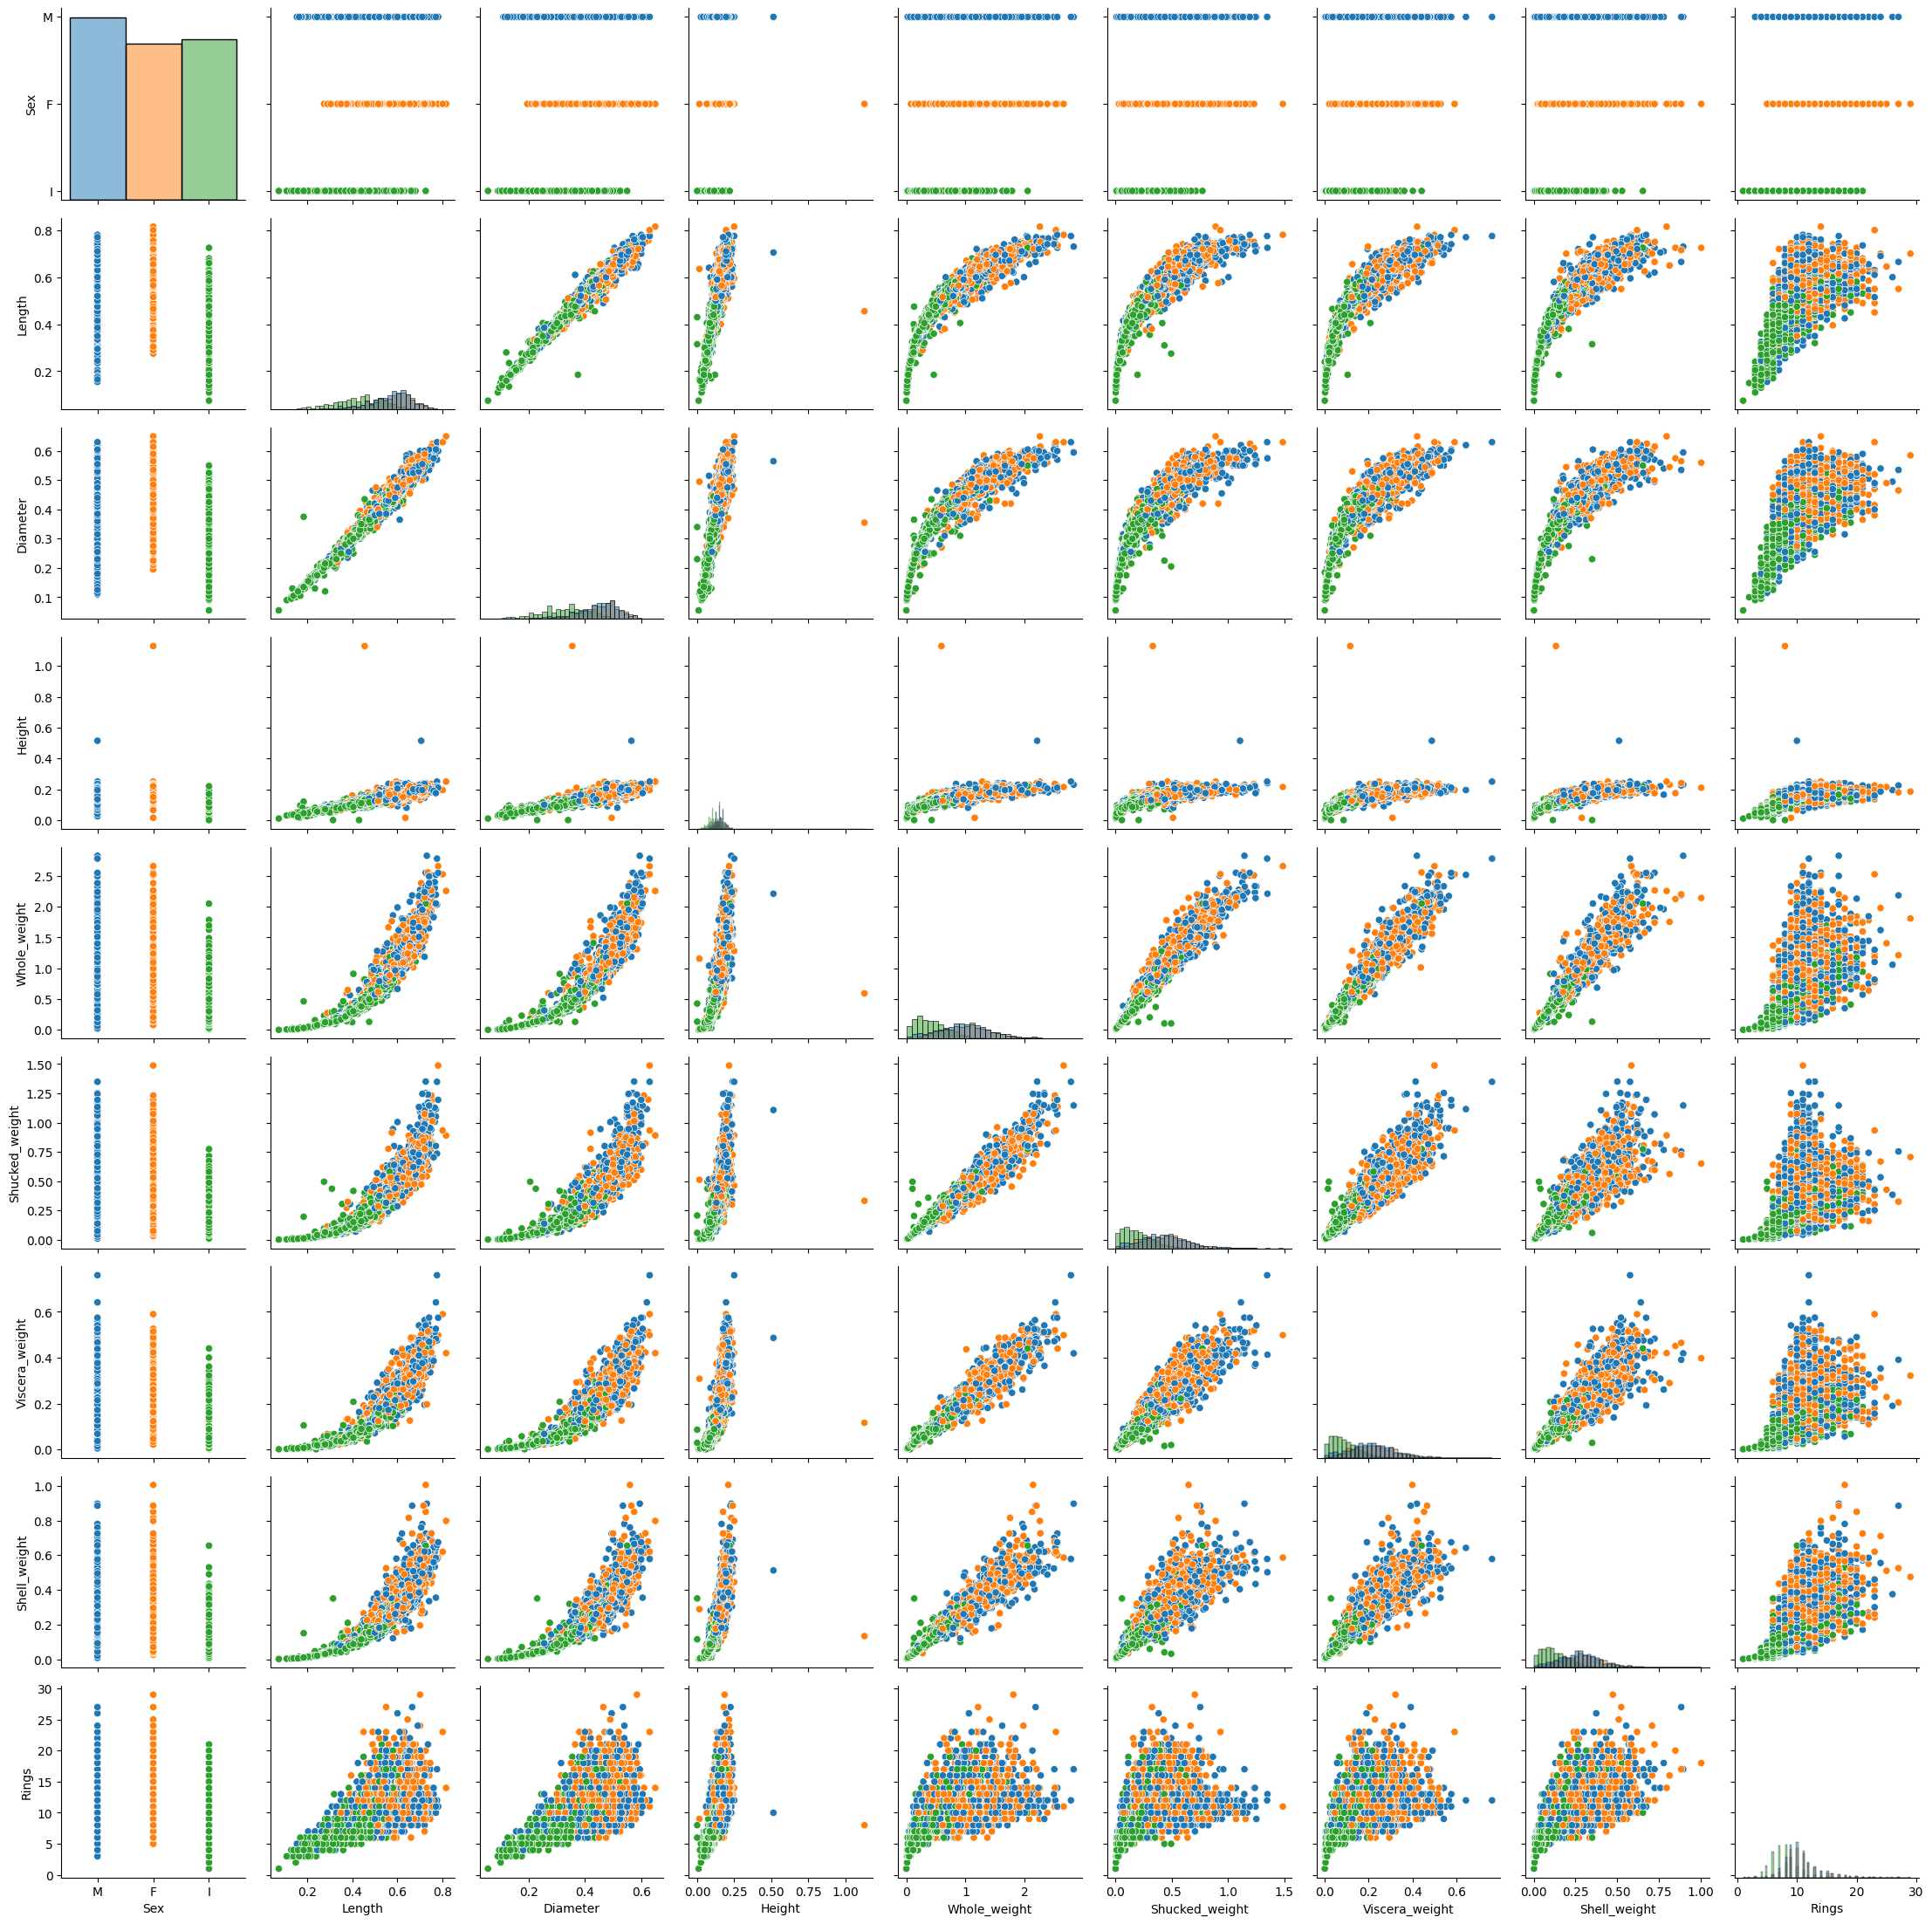

In [7]:
g = sns.PairGrid(df, hue = 'Sex', x_vars = df.columns, y_vars = df.columns)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

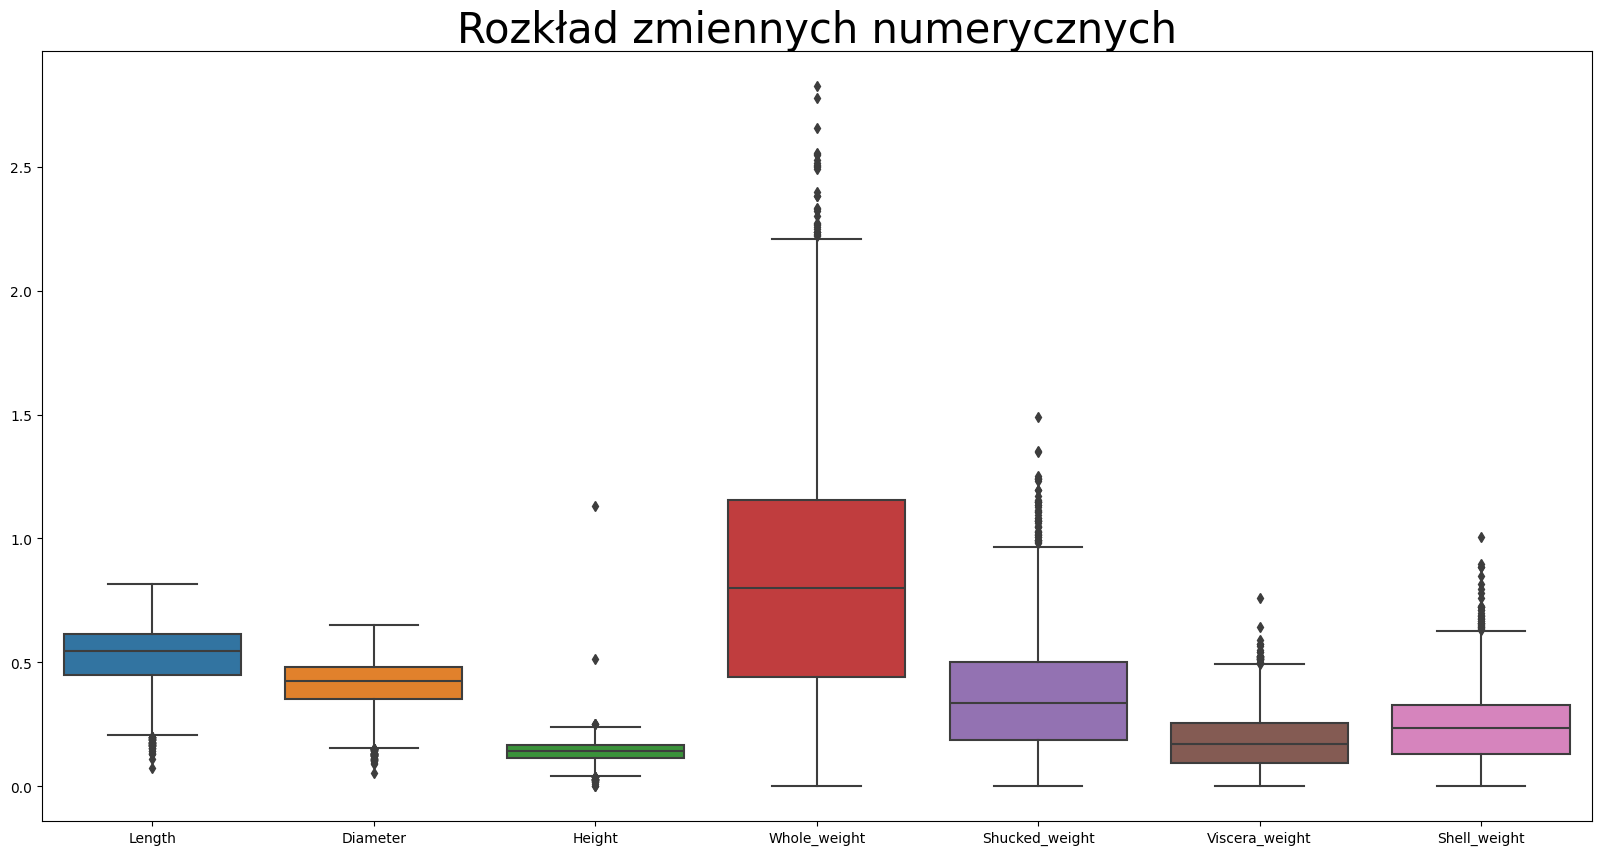

In [8]:
def draw_boxplots(df : pd.DataFrame):
    only_num = df[df.select_dtypes(include = ['float']).columns.tolist()]

    plt.figure(figsize = (20, 10))
    sns.boxplot(only_num)
    plt.title('Rozkład zmiennych numerycznych', fontsize = 30)
    plt.show()
    
    
draw_boxplots(df)

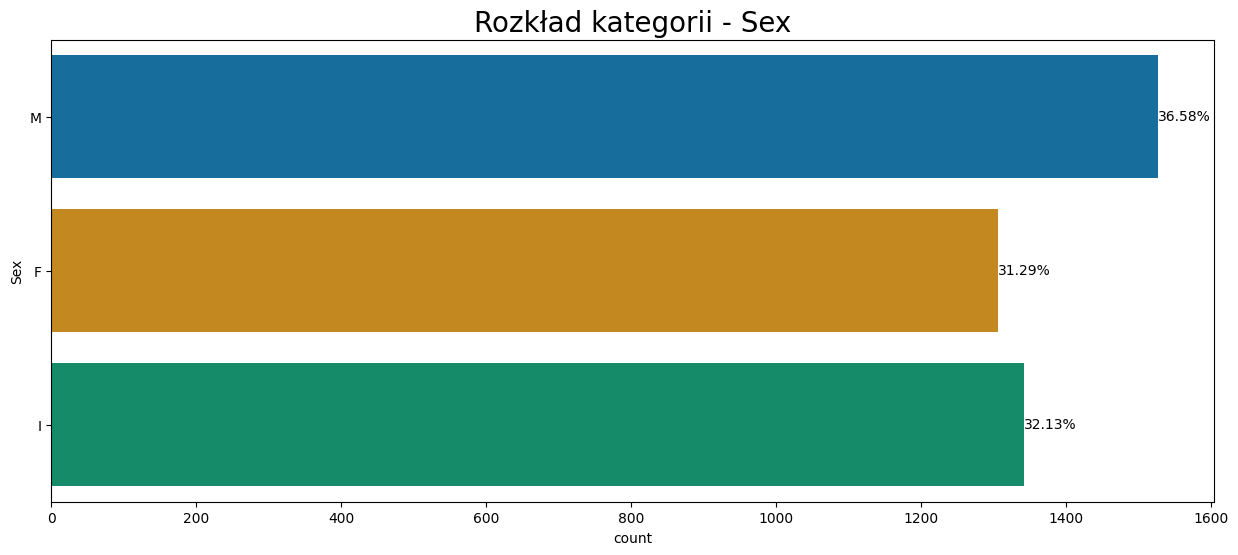

In [9]:
def count_cats(df : pd.DataFrame, dtype : str = 'object'):
    filtered_df = df[df.select_dtypes(include = [dtype]).columns.tolist()]

    fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    ax = sns.countplot(data = filtered_df, y = filtered_df.columns.item(), palette = 'colorblind')
    
    total = len(filtered_df)
    num_bars = len(ax.patches)
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_width() / total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        font_size = min(10, 200 / num_bars)
        ax.annotate(percentage, (x, y), fontsize = font_size, va = 'center')
        
    plt.title(f'Rozkład kategorii - {filtered_df.columns.item()}', fontsize = 20)
    plt.show()
    
    
count_cats(df)

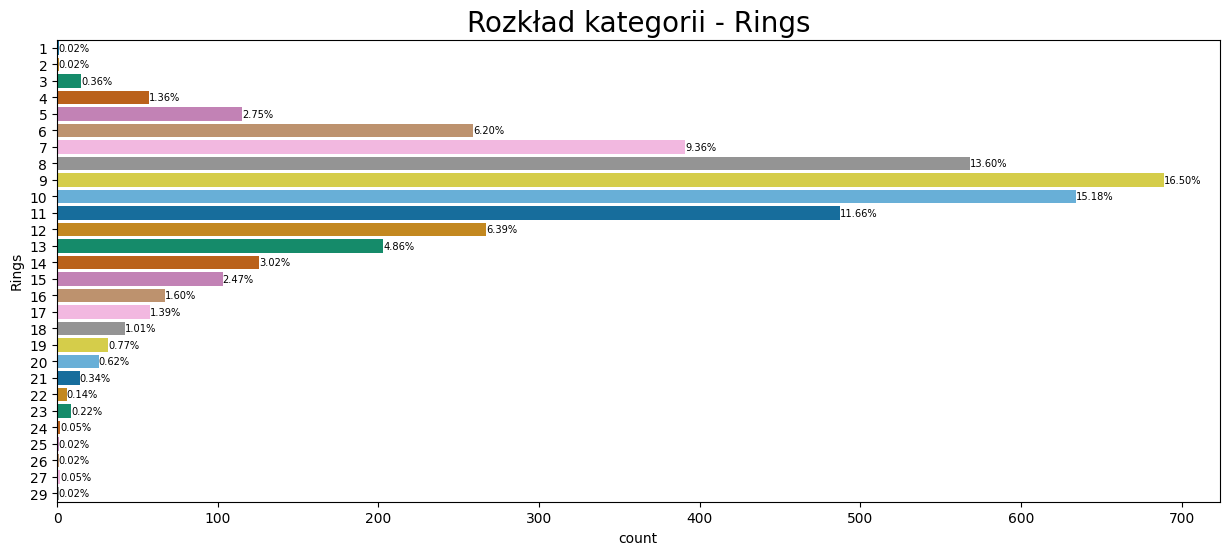

In [10]:
count_cats(df, 'int')

In [11]:
# profile = ProfileReport(df, title = "Abalone AutoEDA")
# profile.to_file("abalone_autoeda.html")

#### Wnioski:

* Zbiór danych dotyczy uchowców (rodzaj skorupiaków morskich)
* Są zawarte takie cechy jak płeć, długość, szerokość, waga (i inne wymiary fizyczne), a także liczba pierścieni która jest wyznacznikiem wieku uchowca
* W zbiorze danych nie ma żadnych brakujących wartości
* Występują natomiast wartości odstające
* Dystrybucja płci jest zbalansowana

## 2. Preprocessing danych

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


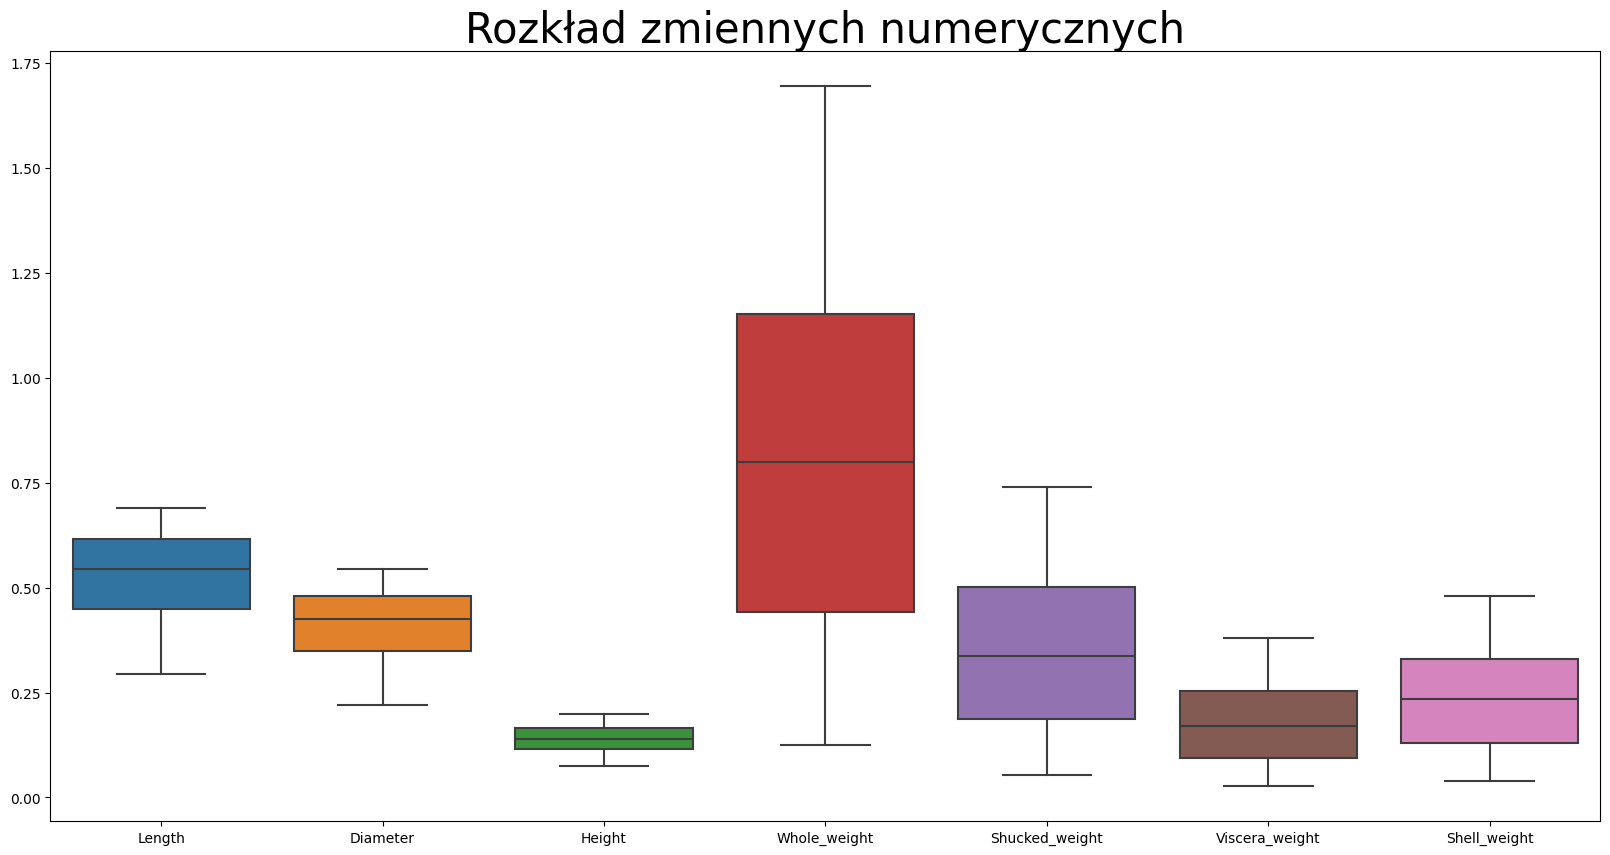

In [12]:
def remove_outliers(df : pd.DataFrame, alpha : float = 0.05):
    df = df.copy()
    num_names = df.select_dtypes(include = ['float']).columns.tolist()
    df[num_names] = df[num_names].clip(lower = df[num_names].quantile(alpha), upper = df[num_names].quantile(1 - alpha), axis = 1)
    return df


no_outliers = remove_outliers(df)
display(no_outliers.head())

draw_boxplots(no_outliers)

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_I,Sex_M
0,0.405063,0.446154,0.16,0.247355,0.250218,0.209870,0.252717,0.500000,0,1
1,0.139241,0.138462,0.12,0.063480,0.068479,0.060976,0.071558,0.214286,0,1
2,0.594937,0.615385,0.48,0.351243,0.296743,0.324731,0.388587,0.285714,0,0
3,0.367089,0.446154,0.40,0.248630,0.237133,0.246739,0.264040,0.321429,0,1
4,0.088608,0.107692,0.04,0.050414,0.053940,0.035451,0.037591,0.214286,1,0
...,...,...,...,...,...,...,...,...,...,...
4172,0.683544,0.707692,0.72,0.485086,0.461762,0.601248,0.476902,0.357143,0,0
4173,0.746835,0.676923,0.48,0.535437,0.562082,0.531764,0.502944,0.321429,0,1
4174,0.772152,0.784615,1.00,0.669280,0.687845,0.738798,0.610507,0.285714,0,1
4175,0.835443,0.815385,0.60,0.617336,0.695842,0.663642,0.583333,0.321429,0,0


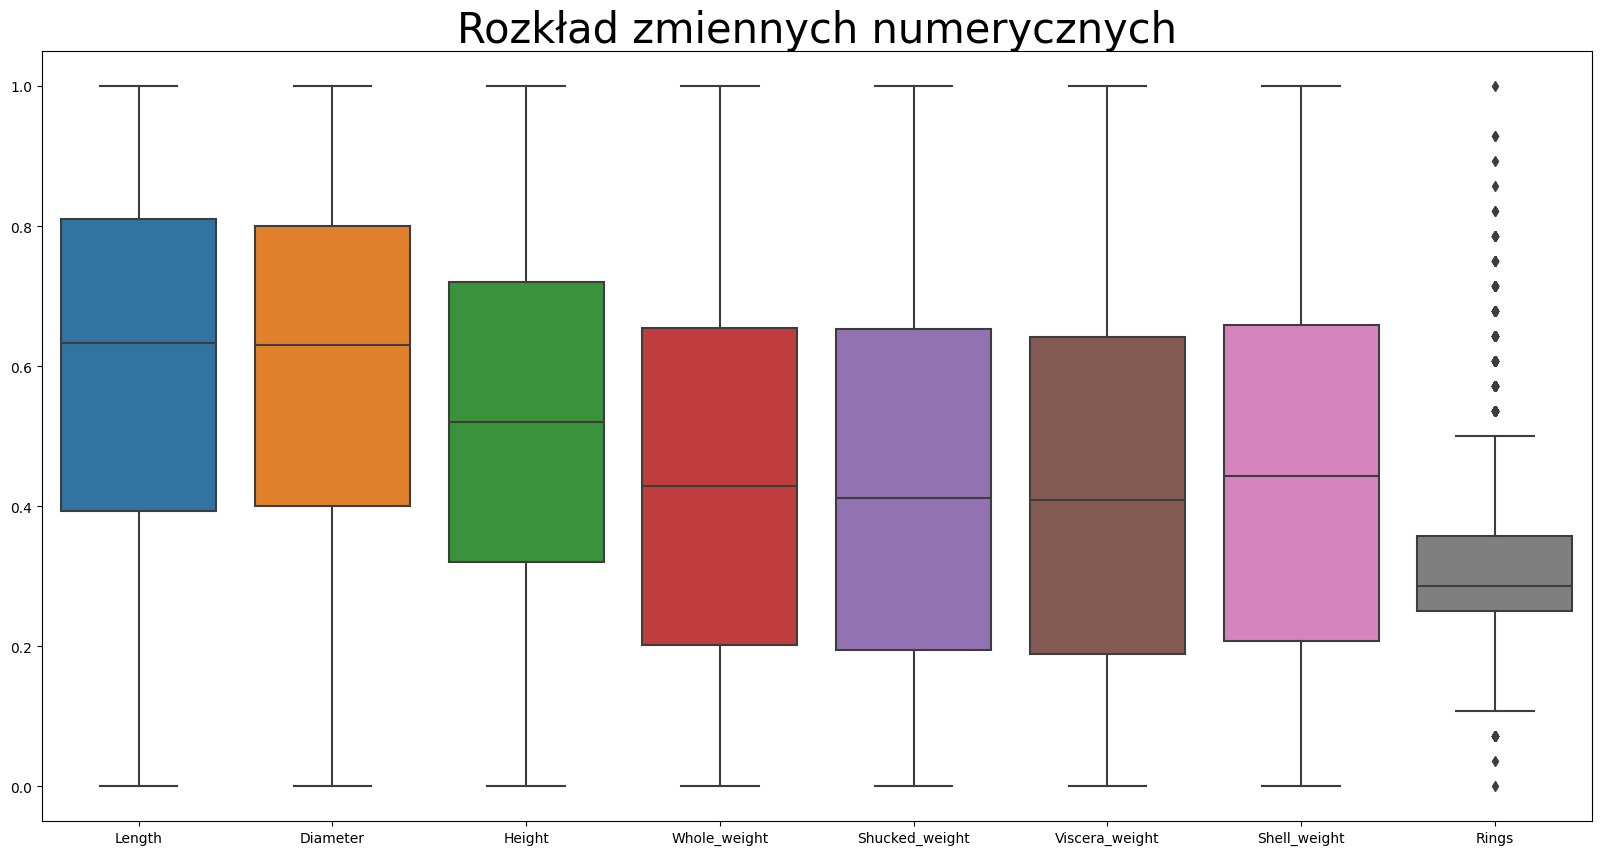

In [13]:
def preprocessor(df : pd.DataFrame):
    df = df.copy()
    
    # Zdefiniowanie transformera i zastosowanie go na danych
    cat = df.select_dtypes(include = ['object']).columns
    num = df.select_dtypes(include = ['int', 'float']).columns
    scaler = MinMaxScaler()
    ohe = OneHotEncoder(drop = 'first')
    preprocessor = make_column_transformer((scaler, num), (ohe, cat), remainder = 'passthrough')
    data = preprocessor.fit_transform(df)
    
    # Nadanie nazw kolumnom w nowym df
    transformed_feature_names = []
    for _, trans, columns in preprocessor.transformers_:
        if trans == 'drop':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            names = trans.get_feature_names_out(input_features = columns)
        else:
            names = columns
        transformed_feature_names.extend(names)
        
    df = pd.DataFrame(data, columns = transformed_feature_names)
    
    # Zmiana typu kolumn po zastosowaniu encodera na int
    cols_to_change_dtype = [col for col in df.columns if any(col.startswith(word) for word in cat)]
    df[cols_to_change_dtype] = df[cols_to_change_dtype].astype(int)
          
    return df


final_df = preprocessor(no_outliers)
display(final_df)
draw_boxplots(final_df)


## 3. K-means, DBSCAN - trenowanie, testowanie

In [51]:
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
from typing import Literal, Optional, Union
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, TSNE

In [56]:
class KMeansModel():
    
    def __init__(self, clusters : list[int]):
        
        self.kwargs = {'init' : 'k-means++', 
              'n_init' : 30, 
              'max_iter' : 300, 
              'algorithm' : 'elkan', 
              'random_state' : 42}
        
        self.clusters = clusters
        self.models = []
        for n_clusters in self.clusters:
            kmeans = KMeans(n_clusters = n_clusters, **self.kwargs)
            self.models.append(kmeans)
            
            
    def fit_models(self, data : Union[pd.DataFrame, np.array], dim_reduction : Union[PCA, TSNE, MDS, Isomap] = None):
        
        self.data = data
        self.dim_reduction = dim_reduction
        
        if type(self.data) is pd.DataFrame:
            self.data = np.array(self.data)
        
        if self.dim_reduction is not None:
            if isinstance(self.dim_reduction, PCA):
                self.dim_reduction.n_components = 2
            elif isinstance(self.dim_reduction, TSNE):
                self.dim_reduction.n_components = 2
                self.dim_reduction.perplexity = 50
            elif isinstance(self.dim_reduction, Isomap):
                self.dim_reduction.n_components = 2
                self.dim_reduction.n_neighbors = 30
            elif isinstance(self.dim_reduction, MDS):
                self.dim_reduction.n_components = 2
            else:
                raise ValueError("Nieprawidłowy typ dim_reduction")
            self.data = self.dim_reduction.fit_transform(self.data)
            
        for model in self.models:
            model.fit_predict(self.data)
            
        return self
    
    
    def elbow_plot(self):
        
        metrics = [model.inertia_ for model in self.models]
        kl = KneeLocator(self.clusters, metrics, curve="convex", direction="decreasing")
        
        plt.figure(figsize = (15, 6))
        plt.style.use("fivethirtyeight")
        kl.plot_knee()
        
        self.elbow = kl.elbow
        if self.elbow is not None:
            knee_x = kl.knee
            knee_y = kl.knee_y
            plt.annotate(f'Elbow point = {self.elbow}', xy=(knee_x, knee_y), xytext=(knee_x + 2, knee_y + 2),
                        arrowprops=dict(facecolor='black', shrink=0.05))
    
    
    def metrics_plot(self):
        
        metric_functions = {
            'silhouette': silhouette_score,
            'calinski_harabasz': calinski_harabasz_score,
            'davies_bouldin': davies_bouldin_score
        }
        metric_names = list(metric_functions.keys())
        
        try:
            for name in metric_names:
                setattr(self, name + '_metrics', [metric_functions[name](self.data, model.labels_) for model in self.models])
        except:
            raise ValueError('Cannot calculate metrics for k = 1')

        fig, axes = plt.subplots(3, 1, figsize = (15, 12), sharex = True)
        plt.style.use("fivethirtyeight")
        axes[0].plot(self.clusters, self.silhouette_metrics, color = 'red')
        axes[1].plot(self.clusters, self.calinski_harabasz_metrics, color = 'green')
        axes[2].plot(self.clusters, self.davies_bouldin_metrics, color = 'blue')
        for i in range(len(metric_names)):
            axes[i].set_ylabel('score')
            axes[i].set_title(metric_names[i].capitalize().replace('_', '-') + ' score')
        axes[2].set_xlabel('clusters')
            
        plt.xticks(self.clusters)
        plt.show()
    
    
    def best_model(self):
        return self.models[self.models.index(self.elbow)]

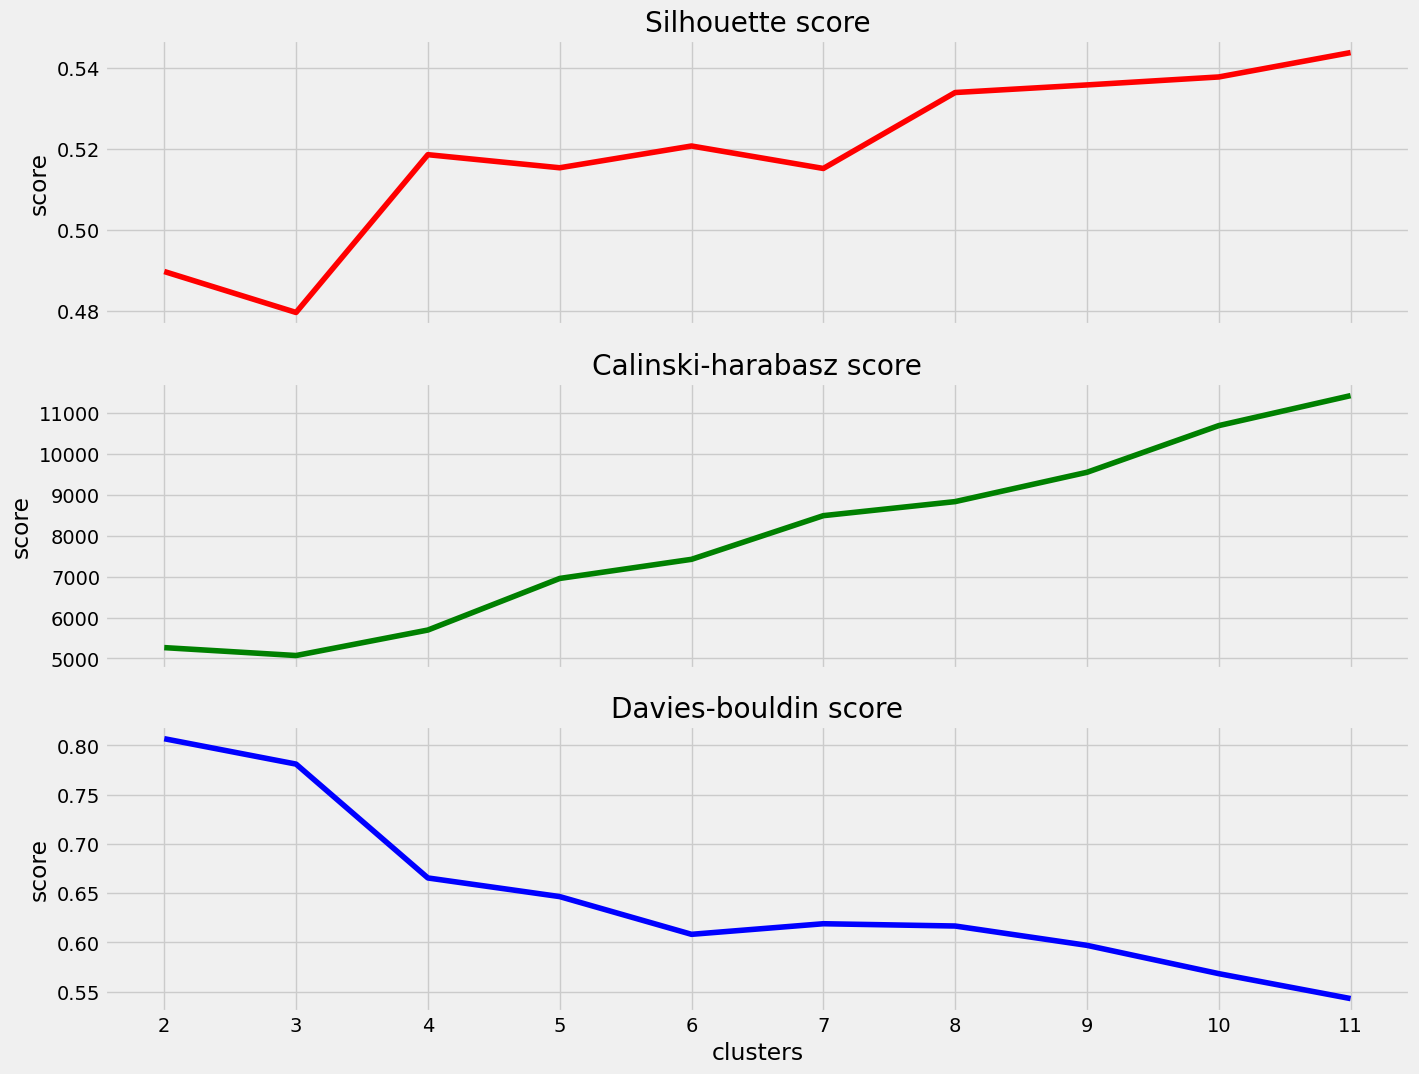

In [55]:
model = KMeansModel(list(range(2, 12)))
model.fit_models(final_df, PCA())
model.metrics_plot()

<Figure size 1500x600 with 0 Axes>

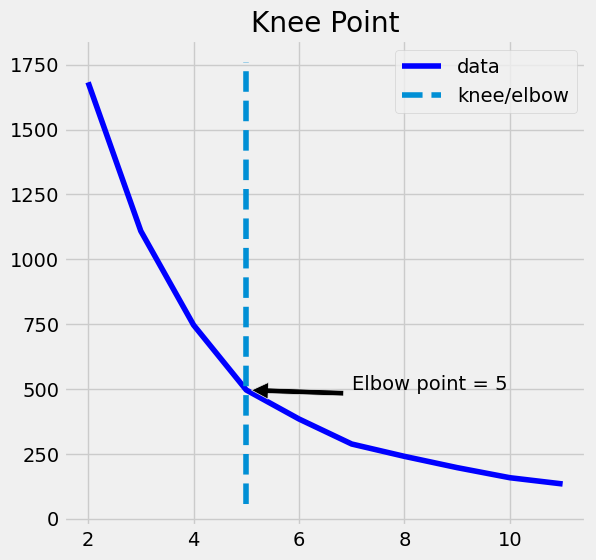

In [57]:
model.elbow_plot()

In [17]:
# def dbscan_model():
    
#     param_grid = {'eps' : }
    
#     DBSCAN()